<a href="https://colab.research.google.com/github/ylmgrbzz/Deep-Learning-Projects-With-Keras-TensorFlow-PyTorch/blob/main/Deep_Dream_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import inception_v3

base_image_path = keras.utils.get_file("yeni.jpg", "https://instagram.fist12-1.fna.fbcdn.net/v/t51.2885-15/294232298_299445059016631_2846947802502978578_n.jpg?stp=dst-jpg_e35_p720x720&_nc_ht=instagram.fist12-1.fna.fbcdn.net&_nc_cat=107&_nc_ohc=6P27GFc3LuwAX8bBCLv&edm=ALQROFkBAAAA&ccb=7-5&ig_cache_key=Mjg4NTkwOTYwOTEyMjM5MTA5Ng%3D%3D.2-ccb7-5&oh=00_AT_cT_axklxuzpDYGvFOVr-CajWtlHAYK7AUD4GzfdRhMQ&oe=6354777A&_nc_sid=30a2ef")
result_prefix = "yeni_dream"

123659/123659 [==============================] - 0s 1us/step


In [2]:
layer_settings = {
    "mixed4": 2.0,
    "mixed5": 3.5,
    "mixed6": 2.0,
    "mixed7": 3.5,
}

In [3]:
step = 0.01  
num_octave = 3  
octave_scale = 1.4  
iterations = 20  
max_loss = 15.0

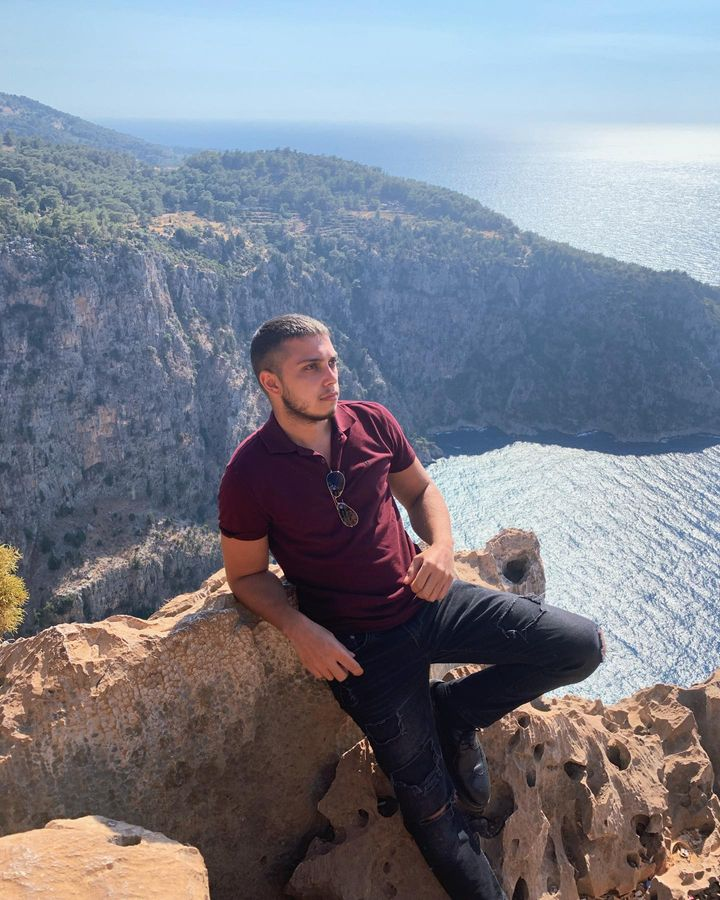

In [5]:
from IPython.display import Image, display
display(Image(base_image_path))


In [6]:
def preprocess_image(image_path):
    img = keras.preprocessing.image.load_img(image_path)
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img

In [7]:
def deprocess_image(x):
    x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.0
    x += 0.5
    x *= 255.0
    x = np.clip(x, 0, 255).astype("uint8")
    return x

In [8]:
model = inception_v3.InceptionV3(weights="imagenet", include_top=False)
outputs_dict = dict(
    [
        (layer.name, layer.output)
        for layer in [model.get_layer(name) for name in layer_settings.keys()]
    ]
)
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)


87910968/87910968 [==============================] - 0s 0us/step


In [9]:
def compute_loss(input_image):
    features = feature_extractor(input_image)
    loss = tf.zeros(shape=())
    for name in features.keys():
        coeff = layer_settings[name]
        activation = features[name]
        scaling = tf.reduce_prod(tf.cast(tf.shape(activation), "float32"))
        loss += coeff * tf.reduce_sum(tf.square(activation[:, 2:-2, 2:-2, :])) / scaling
    return loss

In [10]:
def gradient_ascent_step(img, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img)
    grads = tape.gradient(loss, img)
    grads /= tf.maximum(tf.reduce_mean(tf.abs(grads)), 1e-6)
    img += learning_rate * grads
    return loss, img


def gradient_ascent_loop(img, iterations, learning_rate, max_loss=None):
    for i in range(iterations):
        loss, img = gradient_ascent_step(img, learning_rate)
        if max_loss is not None and loss > max_loss:
            break
        print("... Loss value at step %d: %.2f" % (i, loss))
    return img

In [11]:
original_img = preprocess_image(base_image_path)
original_shape = original_img.shape[1:3]

successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1]
shrunk_original_img = tf.image.resize(original_img, successive_shapes[0])

img = tf.identity(original_img)  
for i, shape in enumerate(successive_shapes):
    print("Processing octave %d with shape %s" % (i, shape))
    img = tf.image.resize(img, shape)
    img = gradient_ascent_loop(
        img, iterations=iterations, learning_rate=step, max_loss=max_loss
    )
    upscaled_shrunk_original_img = tf.image.resize(shrunk_original_img, shape)
    same_size_original = tf.image.resize(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img

    img += lost_detail
    shrunk_original_img = tf.image.resize(original_img, shape)

keras.preprocessing.image.save_img(result_prefix + ".png", deprocess_image(img.numpy()))

Processing octave 0 with shape (459, 367)
... Loss value at step 0: 1.19
... Loss value at step 1: 1.56
... Loss value at step 2: 2.03
... Loss value at step 3: 2.48
... Loss value at step 4: 2.89
... Loss value at step 5: 3.26
... Loss value at step 6: 3.66
... Loss value at step 7: 4.02
... Loss value at step 8: 4.40
... Loss value at step 9: 4.73
... Loss value at step 10: 5.08
... Loss value at step 11: 5.41
... Loss value at step 12: 5.76
... Loss value at step 13: 6.07
... Loss value at step 14: 6.36
... Loss value at step 15: 6.72
... Loss value at step 16: 7.02
... Loss value at step 17: 7.39
... Loss value at step 18: 7.64
... Loss value at step 19: 7.94
Processing octave 1 with shape (642, 514)
... Loss value at step 0: 1.85
... Loss value at step 1: 2.85
... Loss value at step 2: 3.63
... Loss value at step 3: 4.27
... Loss value at step 4: 4.85
... Loss value at step 5: 5.38
... Loss value at step 6: 5.91
... Loss value at step 7: 6.45
... Loss value at step 8: 6.92
... Los

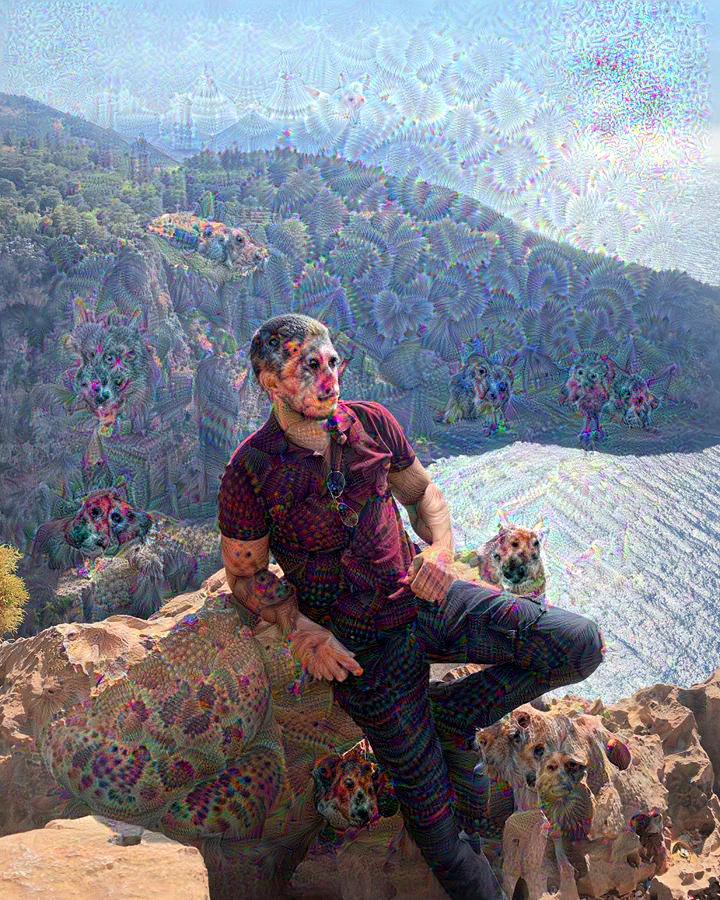

In [12]:
display(Image(result_prefix + ".png"))
